## Introduction
Erwin de Leon and Joeseph Schilling introduce their April 2017 Urban Institute research report ["Urban Blight and Public Health: Addressing the Impact of Substandard Housing, Abandoned Buildings, and Vacant Lots"](https://www.urban.org/research/publication/urban-blight-and-public-health) with the following statement: "We spend more than 2/3rds of our time where we live; thus, housing and neighborhood conditions affect our individual and family's well-being". They also discuss the impact of poor economic conditions that result in "increasing inventories of vacant homes and abandoned buildings". For example, the authors of this report cite Detroit's Blight Removal Task Force's 2014 "strategic plan to address more than 80,000 derelict structures and vacant lots".

This Jupyter notebook illustrates the application of the Python programming language to address three questions regarding the [City of Detroit's Blight Violation Notices (BVN) public domain dataset](https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4):  

1. Is the number of blight violations per month increasing, decreasing, or staying constant over time?  
2. Is the total balance due per month increasing, decreasing, or staying constant over time?  
3. For 2017, are responsible by default blight violation notices clustered as a function of latitute and longitude?  

This analysis lays the groundwork for potentially extending the predictive modeling described in the ["Understanding Blight Ticket Compliance in Detroit"](https://midas.umich.edu/wp-content/uploads/sites/3/2017/09/understanding-blight-ticket.pdf) journal article published at the 2017 Data Science for Social Good Conference in Chicago, IL.  

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import urllib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import folium
from geopy import distance
from folium import plugins

%load_ext pycodestyle_magic
%matplotlib inline

## Prepare Data  
- [Download *.csv from URL](https://stackoverflow.com/questions/41992223/download-csv-from-web-service-with-python-3)  
- [Verify PEP8 in IPython notebook](https://stackoverflow.com/questions/26126853/verifying-pep8-in-ipython-notebook-code)  
- [Tidy Data](https://www.jstatsoft.org/article/view/v059i10)  
- [strftime() and strptime() Behavior](https://docs.python.org/3.7/library/datetime.html#strftime-strptime-behavior)  
- [Rename DataFrame columns](https://chrisalbon.com/python/data_wrangling/pandas_rename_multiple_columns/)  
- [Pandas DataFrame fillna only some columns in-place](https://stackoverflow.com/questions/38134012/pandas-dataframe-fillna-only-some-columns-in-place)  
- [How to group and count rows by month and year using pandas](https://stackoverflow.com/questions/38792122/how-to-group-and-count-rows-by-month-and-year-using-pandas)  

In [19]:
#%%pycodestyle
def is_invalid_timestamp(timestamp):
    """
    Returns a Boolean that describes whether a timestamp matches a
    format

    INPUT:
        timestamp: String that stores a timestamp

    OUTPUT:
        is_valid: Boolean that describes whether a timestamp
                  matches a format
    """
    timestamp_regex = '[0-9]+/[0-9]+/[0-9]+ [0-9]+:[0-9]+:[0-9]+'

    return re.match(timestamp_regex, timestamp) is not None


def convert_to_datetime(timestamp_string):
    """
    Converts a string to a datetime object

    INPUT:
        timestamp_string: String that stores a timestamp

    OUTPUT:
        timestamp: datetime object"""
    return datetime.strptime(timestamp_string,
                             '%m/%d/%Y %H:%M:%S')


def read_bvn_csvfile(bvn_csvfile):
    """
    Loads a City of Detroit Blight Violation Notices *.csv file

    INPUT:
        bvn_csvfile; String that stores the full path to a City of
                     Detroit Blight Violation Notices *.csv file

    OUTPUT:
        bvn_df: Pandas DataFrame that stores City of Detroit
                Blight Violation Notices (BVN)
    """
    df = pd.read_csv(bvn_csvfile, low_memory=False)

    print("(# of rows, # of columns): (%d, %d)" % (df.shape[0],
                                                   df.shape[1]))

    # Transform column names to "tidy data format"
    # https://www.jstatsoft.org/article/view/v059i10
    df.columns = [re.sub("[\\s\\(\\)-]", '', elem).lower()
                  for elem in df.columns]

    # Combine violationdate & ticketissuedtime
    df['violationdatetime'] =\
        df['violationdate'] + ' ' + df['ticketissuedtime']

    # Filter invalid timestamp
    is_valid_datetime =\
        df['violationdatetime'].apply(lambda elem: is_invalid_timestamp(elem))

    percentage_valid_datetime =\
        is_valid_datetime.sum() * (100 / df.shape[0])

    print("Percentage of valid date/time: %.2f" %
          (percentage_valid_datetime))

    df = df[is_valid_datetime]

    # Convert timestamp from string to datetime object
    df['violationdatetime'] =\
        df['violationdatetime'].apply(lambda elem: convert_to_datetime(elem))

    # violationlocation - contains duplicate information
    columns_to_filter = ['violationdate',
                         'ticketissuedtime',
                         'violationlocation']

    df = df.filter([elem for elem in df.columns
                    if elem not in columns_to_filter])

    return df


def init_valuecounts_df(df,
                        column):
    """
    Returns a Pandas DataFrame that stores the histogram of a
    categorical variable

    INPUT:
        df: Pandas DataFrame

        column: String that refers to a DataFrame column

    OUTPUT:
        valuecounts_df: Pandas DataFrame that stores the histogram
            of a categorical variable
    """
    valuecounts = df[column].value_counts()

    valuecounts = list(zip(valuecounts.index,
                           valuecounts.values))

    valuecounts_df = pd.DataFrame(valuecounts,
                                  columns=[column, 'count'])

    valuecounts_df['percentage'] =\
        valuecounts_df['count'] * 100 / valuecounts_df['count'].sum()

    return valuecounts_df


def compute_violationdatetime_histogram(df):
    """
    Computes a violation date/time histogram

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

    OUTPUT:
        violationdatetime_histogram_df: Pandas DataFrame that stores
            a violation date/time histogram
    """
    violationdatetime_histogram =\
        df['violationdatetime'].apply(lambda elem: elem.year).value_counts()

    violationdatetime_histogram =\
        list(zip(violationdatetime_histogram.index,
                 violationdatetime_histogram.values))

    violationdatetime_histogram_df = pd.DataFrame(violationdatetime_histogram,
                                                  columns=['year', 'count'])

    return violationdatetime_histogram_df.sort_values('year')


def filter_outlier_violationdatetime(df,
                                     minimum_year_count=10000):
    """
    Filters years that have less than the specified minimum number of
    samples.

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

        minimum_year_count: (Optional) Integer that specifies the
            minimum number of samples per year

    OUTPUT:
        filtered_df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN) that has the requested minimum
            number of samples / year
    """
    filter_data =\
        violationdatetime_histogram_df['count'] < minimum_year_count

    years_to_filter =\
        violationdatetime_histogram_df[filter_data]['year'].values

    select_data =\
        df['violationdatetime'].apply(lambda elem: elem.year
                                      not in years_to_filter)

    percent_filtered = 100 * (1 - select_data.sum() / df.shape[0])

    print("Percentage of data filtered: %.2e %%" % (percent_filtered))

    filtered_df = df.copy()

    return filtered_df[select_data]


def evaluate_percenage_missingrows(df):
    """
    Evaluates the percentage of missing rows for each DataFrame
    column

    INPUT:
        df: Pandas DataFrame

    OUTPUT:
        missing_rows_df: Pandas DataFrame that describes the
            percentage of missing rows for each input DataFrame
            column
    """
    missing_rows = df.isnull().sum(axis=0)
    missing_rows = missing_rows[missing_rows > 0]
    missing_rows = missing_rows.sort_values(ascending=False)
    missing_rows = list(zip(missing_rows.index, missing_rows.values))

    missing_rows_df = pd.DataFrame(missing_rows,
                                   columns=['column', 'count'])

    missing_rows_df['percentmissing'] =\
        missing_rows_df['count'] * (100 / df.shape[0])

    return missing_rows_df


def filter_missing_rows(df,
                        missing_rows_df,
                        percentmissing_threshold=5):
    """
    Filters columns that have a high percentage of missing data

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

        missing_rows_df: Pandas DataFrame that describes the
                         percentage of missing data for each
                         DataFrame column

        percentmissing_threshold: (Optional) Percentage of
                                  missing rows threshold

    OUTPUT:
        filtered_df: Pandas DataFrame that stores City of Detroit
                     Blight Violation Notices (BVN) with less
                     than the specified percent of missing rows
    """
    filter_data =\
        missing_rows_df['percentmissing'] > percentmissing_threshold

    columns_to_keep = [elem for elem in df.columns if elem not in
                       missing_rows_df[filter_data]['column'].values]

    return df.filter(columns_to_keep)


def evaluate_percentage_missingcolumns(df):
    """
    Evaluates the percentage of missing columns

    INPUT:
        df: Pandas DataFrame

    OUTPUT:
        missing_columns_df: Pandas DataFrame that describes
                            the percentage of missing columns
    """
    missing_columns = df.isnull().sum(axis=1).value_counts()

    missing_columns = list(zip(missing_columns.index,
                               missing_columns.values))

    missing_columns_df = pd.DataFrame(missing_columns,
                                      columns=['missingcolumns',
                                               'count'])

    missing_columns_df['percentmissing'] =\
        missing_columns_df['missingcolumns'] * (100 / df.shape[1])

    return missing_columns_df


def filter_missing_columns(df,
                           missing_columns_df,
                           percentmissing_threshold=5):
    """
    Filters rows with a high percentage of missing columns

    INPUT:
        df: Pandas DataFrame

        missing_columns_df: Pandas DataFrame that describes
            percentage of missing columns / row statistics

        percentmissing_threshold: (Optional) Percentage of missing
            columns threhsold
    """
    filter_data =\
        missing_columns_df['percentmissing'] > percentmissing_threshold

    missingcols_threshold =\
        missing_columns_df[filter_data]['missingcolumns'].min()

    return df[df.isnull().sum(axis=1) < missingcols_threshold]


def filter_columns(df,
                   columns_to_filter):
    """
    Filters Pandas DataFrame columns

    INPUT:
        df: Pandas DataFrame before filtering columns

        columns_to_filter: list of columns to filter

    OUTPUT:
        filtered_df: Pandas DataFrame after filtering columns
    """
    return df.filter([elem for elem in df.columns
                      if elem not in columns_to_filter])


def fillna_mode(df,
                columns_to_impute):
    """
    Fills missing values with the most frequency value (i.e. mode)

    INPUT:
        df: Pandas DataFrame before imputing missing values in
            the requested columns

        columns_to_impute: List of columns to impute missing
            values for

    OUTPUT:
        imputed_df: Pandas DataFrame after imputing missing values
            in the requested columns
    """
    fill_na = {}

    for elem in columns_to_impute:
        fill_na[elem] = df[elem].mode().values[0]

    return df.fillna(fill_na)


def drop_missing_rows(df,
                      columns_to_filter):
    """
    Drops missing rows

    INPUT:
        df: Pandas data frame before dropping missing rows

        columns_to_filter: List of columns to evaluate

    OUTPUT:
        filtered_df: Pandas data frame after dropping missing
            rows
    """
    filtered_df = df.copy()

    for elem in columns_to_filter:
        filtered_df = filtered_df[filtered_df[elem].notnull()]

    return filtered_df


def init_month_year(datetime_multiindex):
    """
    Returns a list of tuples that corresponds to a Pandas (year,
    month) MultiIndex

    INPUT:
        datetime_multiindex: Pandas (year, month) MultiIndex

    OUTPUT:
        month_year: list of tuples that corresponds to a Pandas
            (year, month) MultiIndex
    """
    return [datetime(elem[0], elem[1], 1)
            for elem in datetime_multiindex]


def compute_violations_permonth(df):
    """
    Computes the number of City of Detroit blight violations per
    month

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

    OUTPUT:
        number_violations_df: Pandas DataFrame that stores the
            number of blight violations per month
    """
    year = df.violationdatetime.dt.year

    month = df.violationdatetime.dt.month

    number_violations =\
        df['violationdatetime'].groupby([year,
                                         month]).agg('count')

    month_year = init_month_year(number_violations.index)

    number_violations = list(zip(month_year, number_violations.values))

    return pd.DataFrame(number_violations,
                        columns=["monthyear", "count"])


def compute_totaldue(df):
    """
    Computes the total balance due for blight violations per month

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

    OUTPUT:
        total_due_df: Pandas DataFrame that stores the total
            balance due for blight violations per month
    """
    year = df.violationdatetime.dt.year
    month = df.violationdatetime.dt.month

    total_due = df['balancedue'].groupby([year, month]).agg('sum')

    month_year = init_month_year(total_due.index)

    total_due = list(zip(month_year, total_due.values))

    total_due_df = pd.DataFrame(total_due,
                                columns=["monthyear", "totaldue"])

    total_due_df['totalduethousands'] = total_due_df['totaldue'] / 1e3

    return total_due_df


def select_year(df,
                year):
    """
    Returns a Boolean 1-D array that selects blight violation notices
    for a specific year

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

        year: Integer that refers to a specific year

    OUTPUT:
        select_data: Boolean 1-D array that selects blight violation
            notices for a specific year
    """
    return df[bvn_df.violationdatetime.dt.year == year]


def compute_avgdistance_miles(df):
    """
    Computes the average distance from each violation (latitude,
    longitude) Kmeans cluster.

    INPUT:
        df: Pandas DataFrame that stores City of Detroit Blight
            Violation Notices (BVN)

    OUTPUT:
        avg_distance_miles_df: Pandas DataFrame that stores the
            average distance from each violation (latitude,
            longitude) Kmeans cluster.
    """
    avg_distance_miles = []

    for clusterid in df['cluster'].unique():

        is_cur_cluster = df['cluster'] == clusterid

        cur_latitude = df[is_cur_cluster]['violationlatitude'].values
        cur_longitude = df[is_cur_cluster]['violationlongitude'].values

        cur_centroid = (np.mean(cur_latitude), np.mean(cur_longitude))
        cur_nsamples = len(cur_latitude)
        distance_miles = np.zeros(cur_nsamples)

        for idx in range(cur_nsamples):
            cur_point = (cur_latitude[idx], cur_longitude[idx])

            distance_miles[idx] = distance.distance(cur_point,
                                                    cur_centroid).miles

        avg_distance_miles.append((clusterid, np.mean(distance_miles)))

    avg_distance_miles_df = pd.DataFrame(avg_distance_miles,
                                         columns=['clusterid',
                                                  'avgeragedistancemiles'])
    avg_distance_miles_df =\
        avg_distance_miles_df.sort_values('avgeragedistancemiles')

    return avg_distance_miles_df.reset_index(drop=True)

### Download Data

In [3]:
#%%pycodestyle
csv_url = "https://data.detroitmi.gov/api/views/ti6p-wcg4" +\
          "/rows.csv?accessType=DOWNLOAD"

data_dir = './Data'
csv_file = os.path.join(data_dir, 'rows.csv')

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    urllib.request.urlretrieve(csv_url, csv_file)

### Load Blight Violation Notices Data

In [4]:
#%%pycodestyle
bvn_df = read_bvn_csvfile(csv_file)

(# of rows, # of columns): (392050, 40)
Percentage of valid date/time: 99.98


### Filter Outlier Timestamps
-[Rotate axis text in Python](https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib)  

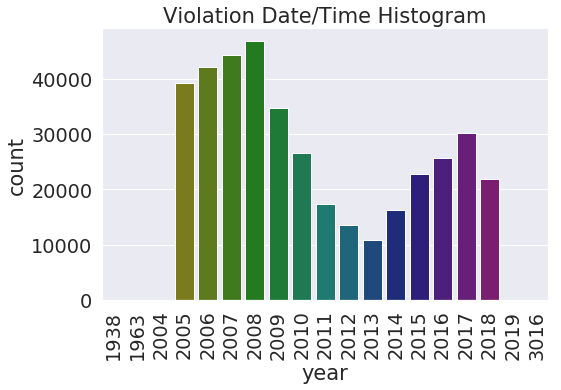

In [5]:
#%%pycodestyle
figure_dir = "./Figures"
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

violationdatetime_histogram_df = compute_violationdatetime_histogram(bvn_df)

palette = sns.hls_palette(violationdatetime_histogram_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(8, 5))
sns.barplot(x='year',
            y='count',
            data=violationdatetime_histogram_df,
            palette=palette)
plt.xticks(rotation=90)
plt.title('Violation Date/Time Histogram')
plt.savefig(os.path.join(figure_dir, "violationdattime.png"))

In [6]:
bvn_df = filter_outlier_violationdatetime(bvn_df)

Percentage of data filtered: 7.65e-03 %


### Filter Columns With A High Percentage of Missing Data
-[Yiran Dong and Chao-Ying Joanne Peng "Principled missing data methods for researchers"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/)

In [7]:
missing_rows_df = evaluate_percenage_missingrows(bvn_df)

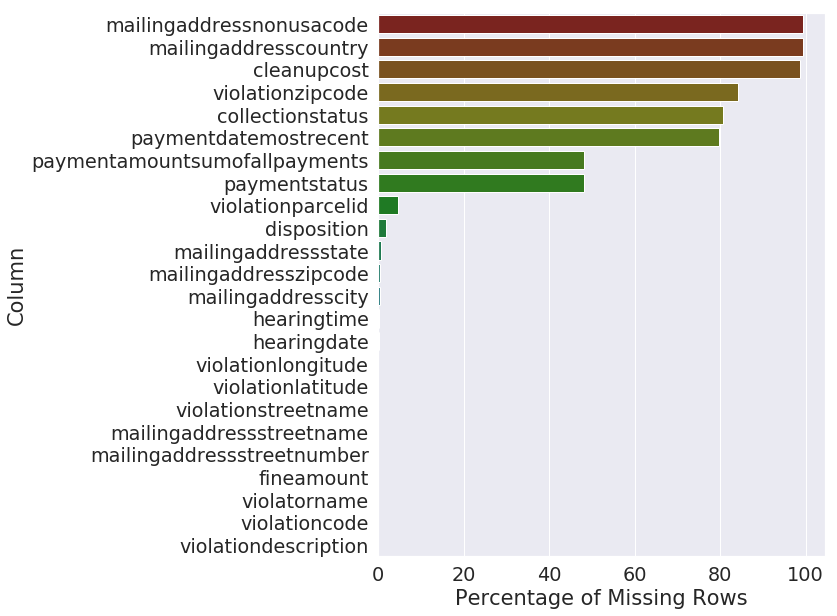

In [8]:
#%%pycodestyle
palette = sns.hls_palette(missing_rows_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(8, 10))
sns.barplot(x='percentmissing',
            y='column',
            data=missing_rows_df,
            palette=palette)
plt.xlabel('Percentage of Missing Rows')
plt.ylabel('Column')
plt.savefig(os.path.join(figure_dir, "missingrows.png"))

In [9]:
bvn_df = filter_missing_rows(bvn_df,
                             missing_rows_df)

## Remove Columns with a Large Amount of Missing Data  

In [10]:
missing_columns_df = evaluate_percentage_missingcolumns(bvn_df)

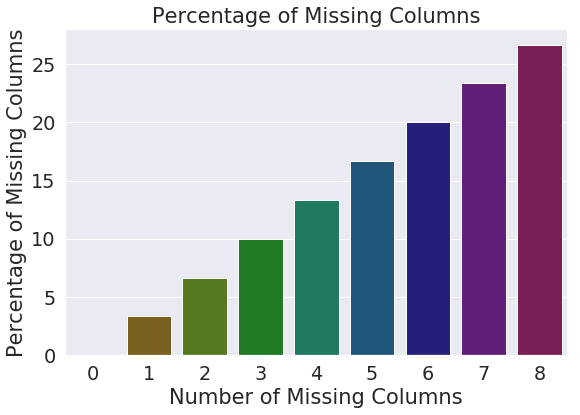

In [11]:
#%%pycodestyle
palette = sns.hls_palette(missing_columns_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(9, 6))
sns.barplot(x='missingcolumns',
            y='percentmissing',
            data=missing_columns_df,
            palette=palette)
plt.xlabel('Number of Missing Columns')
plt.ylabel('Percentage of Missing Columns')
plt.title('Percentage of Missing Columns')
plt.savefig(os.path.join(figure_dir, "missingcolumns.png"))

In [12]:
bvn_df = filter_missing_columns(bvn_df,
                                missing_columns_df)

### Handle Missing Data
- Drop violationparcelid 
   - Related to (latitude, longitude)
   - [Parcel-Points-Ownership](https://data.detroitmi.gov/Property-Parcels/Parcel-Points-Ownership/dxgi-9s8s)  
- Drop mailingaddressstreetname, mailingaddresszipcode, mailingaddressstreetnumber, violatorname, & fineamount missing data  
    - Very small percentage of rows are missing  
- Impute missing dispositions & mailingaddressstate with the most common value  

In [13]:
missing_rows_df = evaluate_percenage_missingrows(bvn_df)
missing_rows_df

,column,count,percentmissing
0,violationparcelid,17370,4.465250
1,disposition,6017,1.546771
2,mailingaddressstate,458,0.117737
3,mailingaddressstreetname,3,0.000771
4,mailingaddresszipcode,2,0.000514
5,mailingaddressstreetnumber,2,0.000514
6,violatorname,2,0.000514
7,fineamount,1,0.000257


In [14]:
bvn_df = filter_columns(bvn_df,
                        ['violationparcelid'])

### Visualize Disposition Statistics

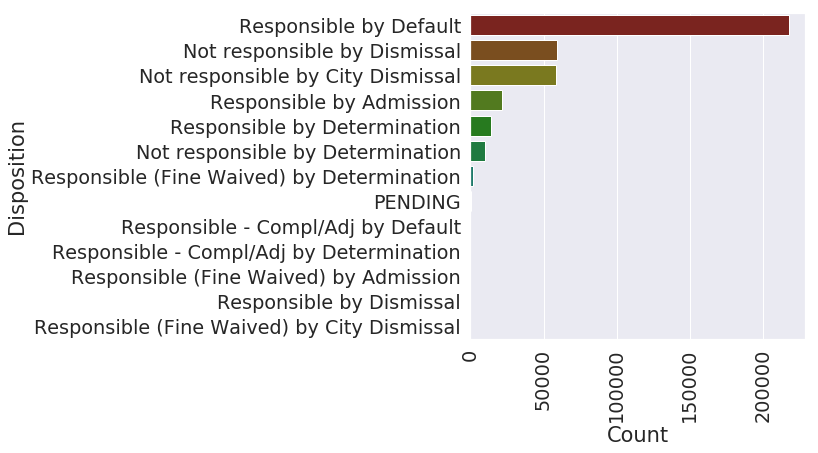

In [15]:
#%%pycodestyle
disposition_df = init_valuecounts_df(bvn_df,
                                     'disposition')

palette = sns.hls_palette(disposition_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(6, 6))
sns.barplot(x='count',
            y='disposition',
            data=disposition_df,
            palette=palette)
plt.xlabel('Count')
plt.ylabel('Disposition')
plt.xticks(rotation=90)
plt.savefig(os.path.join(figure_dir, "dispositionstatistics.png"))

### Evaluate Mailing Address State Statistics

In [16]:
#%%pycodestyle
mailingaddressstate_df = init_valuecounts_df(bvn_df,
                                             'mailingaddressstate')

mailingaddressstate_df.head(n=10)

,mailingaddressstate,count,percentage
0,MI,348331,89.649874
1,CA,8899,2.290334
2,FL,4749,1.222249
3,TX,4230,1.088674
4,NY,2393,0.615886
5,IL,1860,0.478708
6,SC,1804,0.464295
7,OH,1514,0.389658
8,NV,1255,0.322999
9,GA,930,0.239354


### Impute Missing Data

In [17]:
#%%pycodestyle
bvn_df = fillna_mode(bvn_df, ['disposition',
                              'mailingaddressstate'])

### Drop Rows with Missing Data

In [20]:
#%%pycodestyle
columns_to_filter = ['mailingaddressstreetname',
                     'mailingaddresszipcode',
                     'mailingaddressstreetnumber',
                     'violatorname',
                     'fineamount']

bvn_df = drop_missing_rows(bvn_df, columns_to_filter)

assert bvn_df.isnull().sum().sum() == 0, "Missing data found"

# Analyze, Model, and Visualize
1. Is the number of blight violations per month increasing, decreasing, or staying constant over time?  
2. Is the total balance due due per month increasing, decreasing, or staying constant over time?  
3. For 2017, are responsible by default blight violation notices clustered as a function of latitute and longitude?  

In [21]:
number_violations_df = compute_violations_permonth(bvn_df)

### Number of Blight Violation Notices / Month Analysis  
There are three conclusions that I drew from my analysis of the number of 
violation notices / month. First, the number of violations per month peaked during the [2008 housing crisis](https://www.theguardian.com/world/2009/nov/01/detroit-michigan-economy-recession-unemployment). Second, the results suggest that the number of violations dropped from 2009 to 2014. Third, I observed an upward trend in the number of violations per month from 2014 to the present.  

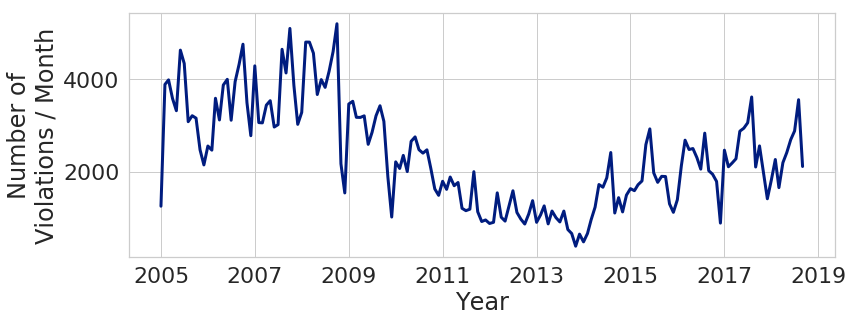

In [22]:
palette = sns.color_palette('dark')

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid", font_scale=2)
sns.lineplot(x='monthyear',
             y='count',
             data=number_violations_df,
             linewidth=3,
             color=palette[0])
plt.tight_layout()
plt.xlabel('Year')
plt.ylabel('Number of\nViolations / Month');
plt.savefig(os.path.join(figure_dir, "violationspermonth.png"))

### Total Blight Violation Fines Due / Month Analysis   
There are three conclusions that I drew from my analysis of the total blight violation fines due / month. First, the total amount due peaked peaked during the [2008 housing crisis](https://www.theguardian.com/world/2009/nov/01/detroit-michigan-economy-recession-unemployment). Second, the results suggest that the total fines due per month decreased from 2009 to 2014. Third, the significant increase in the total fines / month during August 2017 is consistent with [Detroit Mike Duggan's blight removal program announcment on August 10, 2017](http://www.dbusiness.com/daily-news/Annual-2017/Detroit-Mayor-Launches-48M-Board-Up-Brigades-Program-to-Address-Urban-Blight/).  

In [23]:
total_due_df = compute_totaldue(bvn_df)

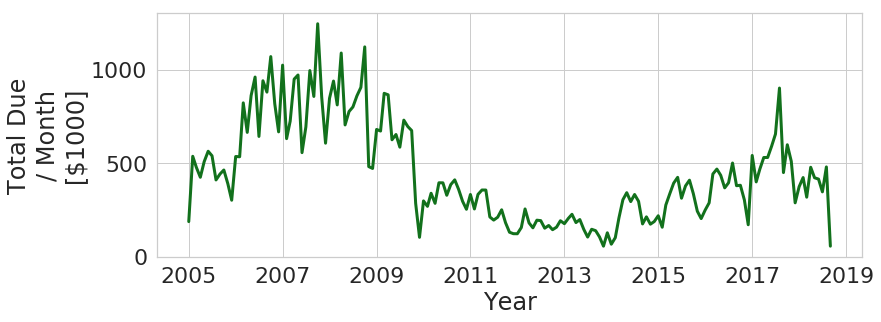

In [24]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid", font_scale=2)
sns.lineplot(x='monthyear',
             y='totalduethousands',
             data=total_due_df,
             linewidth=3,
             color=palette[2])
plt.tight_layout()
plt.xlabel('Year')
plt.ylabel('Total Due\n/ Month\n[$1000]')
plt.savefig(os.path.join(figure_dir, "totaldue.png"))

In [25]:
is_2017 = total_due_df.monthyear.dt.year == 2017
total_due_df[is_2017]

,monthyear,totaldue,totalduethousands
144,2017-01-01,540668.11,540.66811
145,2017-02-01,399182.01,399.18201
146,2017-03-01,466751.53,466.75153
147,2017-04-01,529721.45,529.72145
148,2017-05-01,529694.98,529.69498
149,2017-06-01,590144.35,590.14435
150,2017-07-01,655106.60,655.10660
151,2017-08-01,901016.92,901.01692
152,2017-09-01,448927.70,448.92770
153,2017-10-01,597773.23,597.77323


### Responsible by Default Blight Violation Notices Cluster Analysis

# of rows: 18472


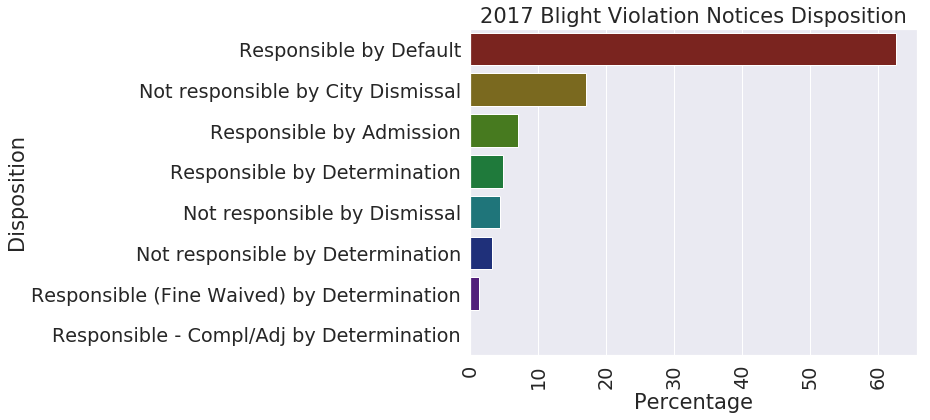

In [27]:
filtered_bvn_df = select_year(bvn_df, 2017)

disposition_df = init_valuecounts_df(filtered_bvn_df,
                                     'disposition')

palette = sns.hls_palette(disposition_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(8, 6))
sns.barplot(x='percentage',
            y='disposition',
            data=disposition_df,
            palette=palette)
plt.xlabel('Percentage')
plt.ylabel('Disposition');
plt.xticks(rotation=90);
plt.title('2017 Blight Violation Notices Disposition');

filtered_bvn_df =\
    filtered_bvn_df[filtered_bvn_df['disposition'] == 'Responsible by Default']

print("# of rows: %d" % (filtered_bvn_df.shape[0]))
plt.savefig(os.path.join(figure_dir, "2017disposition.png"))

### Visualize the Responsible by Default Violations
- [Creating Interactive Crime Maps with Folium](https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/)  
- [Folium library](https://pypi.org/project/folium/)  
- [Export map as png](https://stackoverflow.com/questions/44800396/python-ipyleaflet-export-map-as-png-or-jpg-or-svg)
- © OpenStreetMap contributors  
- [Open Street Map Copyright](https://www.openstreetmap.org/copyright)  

In [37]:
maps_dir = "./Maps"
if not os.path.exists(maps_dir):
    os.mkdir(maps_dir)

coordinates = list(zip(filtered_bvn_df['violationlatitude'],
                       filtered_bvn_df['violationlongitude']))

center_latitude = np.mean([elem[0] for elem in coordinates])
center_longitude = np.mean([elem[1] for elem in coordinates])

map_osm = folium.Map(location=[center_latitude, center_longitude], zoom_start=11)
map_osm.add_child(plugins.HeatMap(coordinates, min_opacity=0.1, radius=10))
map_osm.save(os.path.join(maps_dir, "full.html"))
map_osm

### Apply the elbow method to determine the optimal number of clusters
-[KMeans elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/)  

In [29]:
random_state = 1962636388

scalerobj = StandardScaler()

for elem in ['violationlatitude', 'violationlongitude']:
    filtered_bvn_df['normalized' + elem] =\
        scalerobj.fit_transform(filtered_bvn_df[elem].values.reshape(-1, 1))

X = filtered_bvn_df[['normalizedviolationlatitude',
                     'normalizedviolationlongitude']].values

n_clusters = np.array(range(2, 20))
avg_distance = np.zeros(n_clusters.shape[0])

for idx, cur_nclusters in enumerate(n_clusters):
    print("n_cluster: %d" % (cur_nclusters))
    clusterobj = KMeans(n_clusters=cur_nclusters,
                        random_state=random_state)

    clusterobj.fit(X)

    avg_distance[idx] = np.sum(np.min(cdist(X,
                                            clusterobj.cluster_centers_,
                                           'euclidean'),
                                      axis=1)) / X.shape[0]

n_cluster: 2
n_cluster: 3
n_cluster: 4
n_cluster: 5
n_cluster: 6
n_cluster: 7
n_cluster: 8
n_cluster: 9
n_cluster: 10
n_cluster: 11
n_cluster: 12
n_cluster: 13
n_cluster: 14
n_cluster: 15
n_cluster: 16
n_cluster: 17
n_cluster: 18
n_cluster: 19


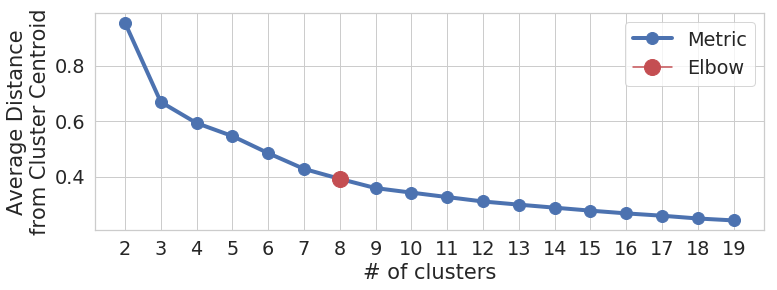

In [31]:
elbow_idx = 6

sns.set_style('whitegrid')
plt.figure(figsize=(12, 4))

plt.plot(n_clusters,
         avg_distance,
         linewidth=4,
         marker='o',
         markersize=12)
plt.plot(n_clusters[elbow_idx],
         avg_distance[elbow_idx],
         c='r',
         marker='o',
         markersize=16)
plt.xticks(n_clusters);
plt.xlabel('# of clusters')
plt.ylabel('Average Distance\nfrom Cluster Centroid')
plt.legend(['Metric', 'Elbow'])
plt.savefig(os.path.join(figure_dir, "kmeans_elbow.png"))

### Fit KMeans Model

In [32]:
clusterobj = KMeans(n_clusters=8, random_state=random_state)

clusterobj.fit(X)

filtered_bvn_df['cluster'] = clusterobj.predict(X)

### Estimate cluster compactness

In [33]:
avg_distance_miles_df = compute_avgdistance_miles(filtered_bvn_df)

### Plot the Most Compact Cluster  
- © OpenStreetMap contributors  
- [Open Street Map Copyright](https://www.openstreetmap.org/copyright)  

In [38]:
min_distance_clusterid = avg_distance_miles_df.iloc[0]['clusterid'].astype('int')

most_compact_df = filtered_bvn_df[filtered_bvn_df['cluster'] == min_distance_clusterid]

coordinates = list(zip(most_compact_df['violationlatitude'],
                       most_compact_df['violationlongitude']))

center_latitude = np.mean([elem[0] for elem in coordinates])
center_longitude = np.mean([elem[1] for elem in coordinates])

map_osm = folium.Map(location=[center_latitude, center_longitude], zoom_start=12)
map_osm.add_child(plugins.HeatMap(coordinates, min_opacity=0.1, radius=10))
map_osm.save(os.path.join(maps_dir, "most_compact.html"))
map_osm

In [39]:
violationdescription_df = init_valuecounts_df(most_compact_df,
                                              'violationdescription')

violationdescription_df['cumulativepercentage'] =\
    np.cumsum(violationdescription_df['percentage'])

violationdescription_df.head(n=10)

,violationdescription,count,percentage,cumulativepercentage
0,Failure of owner to obtain certificate of comp...,577,19.619177,19.619177
1,Allowing bulk solid waste to lie or accumulate...,441,14.994900,34.614077
2,Excessive weeds or plant growth one- or two-fa...,399,13.566814,48.180891
3,Unlawful occupation of rental property without...,337,11.458688,59.639578
4,Failure to obtain certificate of registration ...,333,11.322679,70.962258
5,Failure to maintain a vacant building or struc...,89,3.026182,73.988439
6,"Failure of owner to keep property, its sidewal...",65,2.210133,76.198572
7,Inoperable motor vehicle(s) one- or two-family...,64,2.176131,78.374702
8,Failure to maintain exterior of one- or two-fa...,63,2.142129,80.516831
9,Fail to comply with an Emergency or imminent d...,52,1.768106,82.284937


In [40]:
for row in range(5):
    print(violationdescription_df.iloc[row]['violationdescription'])

Failure of owner to obtain certificate of compliance
Allowing bulk solid waste to lie or accumulate on or about the premises
Excessive weeds or plant growth one- or two-family dwelling or commercial Building
Unlawful occupation of rental property without lead clearance - one or two-family dwelling
Failure to obtain certificate of registration for rental property


### Plot the Least Compact Cluster  
- © OpenStreetMap contributors  
- [Open Street Map Copyright](https://www.openstreetmap.org/copyright)  

In [41]:
min_distance_clusterid = avg_distance_miles_df.iloc[-1]['clusterid'].astype('int')

least_compact_df = filtered_bvn_df[filtered_bvn_df['cluster'] == min_distance_clusterid]

coordinates = list(zip(least_compact_df['violationlatitude'],
                       least_compact_df['violationlongitude']))

center_latitude = np.mean([elem[0] for elem in coordinates])
center_longitude = np.mean([elem[1] for elem in coordinates])

map_osm = folium.Map(location=[center_latitude, center_longitude], zoom_start=12)
map_osm.add_child(plugins.HeatMap(coordinates, min_opacity=0.1, radius=10))
map_osm.save(os.path.join(maps_dir, "least_compact.html"))
map_osm

In [42]:
violationdescription_df = init_valuecounts_df(least_compact_df,
                                              'violationdescription')

violationdescription_df['cumulativepercentage'] =\
    np.cumsum(violationdescription_df['percentage'])

violationdescription_df.head(n=10)

,violationdescription,count,percentage,cumulativepercentage
0,Excessive weeds or plant growth one- or two-fa...,397,26.152833,26.152833
1,Allowing bulk solid waste to lie or accumulate...,374,24.637681,50.790514
2,Failure of owner to obtain certificate of comp...,149,9.815547,60.606061
3,Inoperable motor vehicle(s) one- or two-family...,86,5.665349,66.271410
4,Failure to obtain certificate of registration ...,59,3.886693,70.158103
5,Failure to maintain a vacant building or struc...,57,3.754941,73.913043
6,"Failure of owner to keep property, its sidewal...",57,3.754941,77.667984
7,Violation of time limit for approved container...,44,2.898551,80.566535
8,Unlawful occupation of rental property without...,34,2.239789,82.806324
9,Fail to comply with an Emergency or imminent d...,28,1.844532,84.650856


In [43]:
for row in range(5):
    print(violationdescription_df.iloc[row]['violationdescription'])

Excessive weeds or plant growth one- or two-family dwelling or commercial Building
Allowing bulk solid waste to lie or accumulate on or about the premises
Failure of owner to obtain certificate of compliance
Inoperable motor vehicle(s) one- or two-family dwelling or commercial building
Failure to obtain certificate of registration for rental property
